# Approximate Nearest Neighbor Search using the Dynamic Exploration Graph

# Setup Python dependencies

In [ ]:
!pip install faiss-cpu deglib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 896.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 552.3/552.3 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 18.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.


In [ ]:
import time
import faiss
import deglib
import numpy as np
import matplotlib.pyplot as plt

# Download and load dataset

Download the SIFT1M dataset, which includes 1 million SIFT feature vectors, 10,000 test queries, and ground truth data specifying the 100 nearest neighbors within the base dataset for each query.

In [ ]:
!curl -L -o sift.tar.gz https://static.visual-computing.com/paper/DEG/sift.tar.gz
!tar -xzf sift.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  154M  100  154M    0     0  20.6M      0  0:00:07  0:00:07 --:--:-- 24.1M


In [ ]:
# Read .fvecs and .ivecs files
def read_fvecs(filename):
    with open(filename, 'rb') as f:
        dim = np.fromfile(f, dtype=np.int32, count=1)[0]
    return np.ascontiguousarray(np.fromfile(filename, dtype=np.float32).reshape(-1, dim + 1)[:, 1:], dtype=np.float32)

def read_ivecs(filename):
    with open(filename, 'rb') as f:
        dim = np.fromfile(f, dtype=np.int32, count=1)[0]
    return np.ascontiguousarray(np.fromfile(filename, dtype=np.int32).reshape(-1, dim + 1)[:, 1:], dtype=np.int32)

# Load data
sift_base = read_fvecs("./sift/sift_base.fvecs")              # base vectors
sift_query = read_fvecs("./sift/sift_query.fvecs")            # queries
sift_query_gt = read_ivecs("./sift/sift_groundtruth.ivecs")   # ground truth indices

print(f"Base shape: {sift_base.shape}, Query shape: {sift_query.shape}")

Base shape: (1000000, 128), Query shape: (10000, 128)


## k-Nearest Neighbor Search (kNNS) with FAISS

Build a FAISS search index with the SIFT1M dataset and use the 10000 search queries to search in this index for the 100 nearest neighbors.

In [ ]:
# Restrict to 1 thread
faiss.omp_set_num_threads(1)

# Get dimensionality
d = sift_base.shape[1]

# Create a FAISS index for L2 distance
start = time.time()
index = faiss.IndexFlatL2(d)
end = time.time()
print(f"FAISS index creation took {end - start:.2f} seconds.")

# Add the base vectors to the index
start = time.time()
index.add(sift_base)
end = time.time()
print(f"FAISS adding data took {end - start:.2f} seconds.")

# Search
k = 100  # number of nearest neighbors
start = time.time()
distances, indices = index.search(sift_query, k)
end = time.time()
qps_scan = len(sift_query) / (end - start)
print(f"FAISS kNNS (1 thread) took {end - start:.2f} seconds.")
print(f"Nearest neighbor indices shape: {indices.shape}")

FAISS index creation took 0.00 seconds.
FAISS adding data took 0.51 seconds.
FAISS kNNS (1 thread) took 75.97 seconds.
Nearest neighbor indices shape: (10000, 100)


# Approximated Nearest Neighbor Search (ANNS)

Use the same dataset to build an approximate nearest neighbor (ANN) search index, and evaluate its performance by comparing the results to the ground truth using the Recall@k metric.

In [ ]:
def recall_at_k(retrieved_indices, ground_truth, k=100):
    """
    Computes Recall@k for nearest neighbor search.

    Parameters:
        retrieved_indices: np.ndarray of shape (num_queries, k)
        ground_truth: np.ndarray of shape (num_queries, 1) – true nearest neighbor indices
        k: int – number of top predictions to check

    Returns:
        recall: float – fraction of queries where ground truth was in top-k
    """
    correct = 0
    for i in range(ground_truth.shape[0]):
        if ground_truth[i, 0] in retrieved_indices[i, :k]:
            correct += 1
    return correct / ground_truth.shape[0]

## ANNS with the Dynamic Exploration Graph (DEG)

Build the Dynamic Exploration Graph using the SIFT1M dataset.

In [ ]:
# Build graph
t0 = time.time()
graph = deglib.builder.build_from_data(
    data=sift_base,
    edges_per_vertex=16,
    extend_k=32,
    extend_eps=0.1,
    improve_k=0,
    lid=deglib.builder.LID.Low,
    callback="progress"
)
t1 = time.time()
print(f"Building the graph took {end - start:.2f} seconds.")

100.00% [############################################################] (1000000 / 1000000)
Building the graph took 75.97 seconds.


Run searches on the graph using the 10,000 test queries, varying the search parameters to observe different Recall@K performance levels and corresponding search speeds.

In [ ]:
recalls_deg = []
qps_deg = []
for eps in [0.01, 0.05, 0.1]:

    # Search
    t0 = time.time()
    results, _ = graph.search(query=sift_query, eps=eps, k=k, threads=1)
    t1 = time.time()
    search_time = t1 - t0
    qps = len(sift_query) / search_time

    # Recall
    recall = recall_at_k(results, sift_query_gt, k)
    recalls_deg.append(recall)
    qps_deg.append(qps)

    # Pretty print
    print(
        f"eps={eps:.3f}, k={k:3d} | "
        f"Recall@{k:<3d}: {recall * 100:6.2f}% | "
        f"QPS: {qps:7.2f} | "
        f"Search: {search_time:6.2f}s"
    )

eps=0.010, k=100 | Recall@100:  96.05% | QPS: 3404.79 | Search:   2.94s
eps=0.050, k=100 | Recall@100:  98.00% | QPS: 2327.73 | Search:   4.30s
eps=0.100, k=100 | Recall@100:  99.24% | QPS: 1792.35 | Search:   5.58s


## Plot the ANNS performance

Create a Recall@K vs. Queries Per Second plot to illustrate the trade-off between search accuracy and efficiency, highlighting the speed gains compared to linear search.

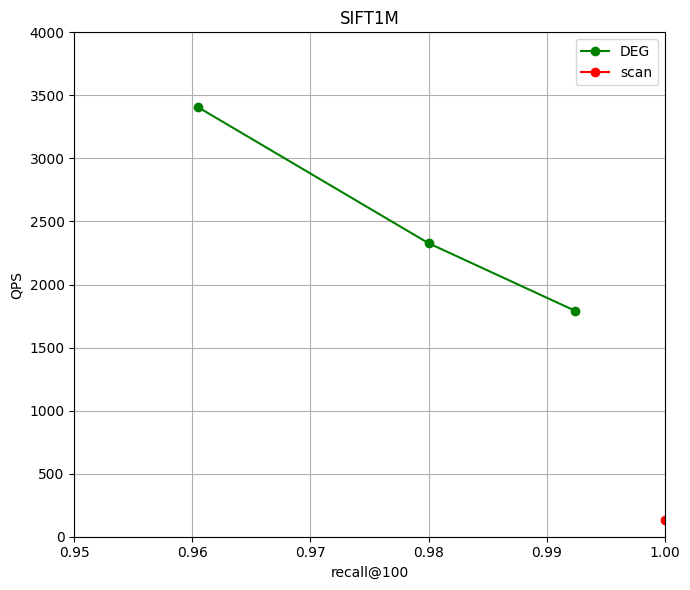

In [ ]:
data = [
    {"label": "DEG", "recalls": recalls_deg, "qps": qps_deg, "color": "green"},
    {"label": "scan", "recalls": [1], "qps": [qps_scan], "color": "red"}
]

plt.figure(figsize=(7, 6))
for d in data:
    plt.plot(d["recalls"], d["qps"], label=d["label"],
             color=d["color"], linestyle="-", marker='o')

plt.xlabel("recall@100")
plt.ylabel("QPS")
plt.title("SIFT1M")
plt.xlim(0.95, 1.0)
plt.ylim(0, 4000)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Removing data points from the graph

Simulate an evolving dataset by removing 100,000 data points from both the dataset and the graph. This removal takes only a few seconds.

In [ ]:
builder = deglib.builder.EvenRegularGraphBuilder(
    graph,
    deglib.std.Mt19937(7),
    lid=deglib.builder.LID.Low,
    extend_k=32,
    extend_eps=0.1,
    improve_k=0
)
for label in np.arange(900000, sift_base.shape[0], dtype=np.uint32):
  builder.remove_entry(label)
builder.build(callback="progress")

100.00% [############################################################] (100000 / 100000)


## Calculate new ground truth data for 900k dataset

Compute the 100 nearest neighbors for the updated dataset of 900,000 data points to establish the ground truth for evaluating Recall@K performance. This recalculation takes nearly as long as the original linear search process.

In [ ]:
# Get dimensionality
d = sift_base.shape[1]

# Create a FAISS index for L2 distance
start = time.time()
index_900k = faiss.IndexFlatL2(d)
index_900k.add(sift_base[:900000])
end = time.time()
print(f"Creating FAISS index took {end - start:.2f} seconds.")

# Search
k = 100  # number of nearest neighbors
start = time.time()
distances_900k, indices_900k = index_900k.search(sift_query, k)
end = time.time()
qps_scan_900k = len(sift_query) / (end - start)
print(f"FAISS kNNS (1 thread) took {end - start:.2f} seconds.")
print(f"Nearest neighbor indices shape: {indices.shape}")

Creating FAISS index took 0.41 seconds.
FAISS kNNS (1 thread) took 63.48 seconds.
Nearest neighbor indices shape: (10000, 100)


## Testing DEG with 900k

Test the Dynamic Exploration Graph against the new ground truth data.

In [ ]:
recalls_deg = []
qps_deg = []
for eps in [0.01, 0.05, 0.1]:

    # Search
    t0 = time.time()
    results, _ = graph.search(query=sift_query, eps=eps, k=k, threads=1)
    t1 = time.time()
    search_time = t1 - t0
    qps = len(sift_query) / search_time

    # Recall
    recall = recall_at_k(results, indices_900k, k)
    recalls_deg.append(recall)
    qps_deg.append(qps)

    # Pretty print
    print(
        f"eps={eps:.3f}, k={k:3d} | "
        f"Recall@{k:<3d}: {recall * 100:6.2f}% | "
        f"QPS: {qps:7.2f} | "
        f"Search: {search_time:6.2f}s"
    )

eps=0.010, k=100 | Recall@100:  96.25% | QPS: 3402.34 | Search:   2.94s
eps=0.050, k=100 | Recall@100:  98.11% | QPS: 2582.95 | Search:   3.87s
eps=0.100, k=100 | Recall@100:  99.27% | QPS: 1639.35 | Search:   6.10s


Plot the updated search efficiency curve.

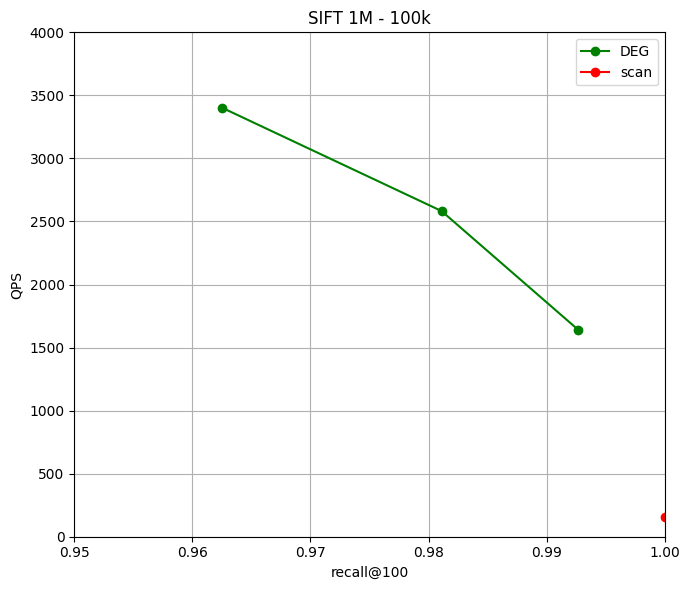

In [ ]:
data = [
    {"label": "DEG", "recalls": recalls_deg, "qps": qps_deg, "color": "green"},
    {"label": "scan", "recalls": [1], "qps": [qps_scan_900k], "color": "red"}
]

plt.figure(figsize=(7, 6))
for d in data:
    plt.plot(d["recalls"], d["qps"], label=d["label"],
             color=d["color"], linestyle="-", marker='o')

plt.xlabel("recall@100")
plt.ylabel("QPS")
plt.title("SIFT 1M - 100k")
plt.xlim(0.95, 1.0)
plt.ylim(0, 4000)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()